In [ ]:
from PIL import Image
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import os

In [ ]:
def save_gif_PIL(outfile, files, fps=5, loop=0):
    """Helper function for saving GIFs"""
    imgs = [Image.open(file) for file in files]
    imgs[0].save(fp=outfile, format='GIF', append_images=imgs[1:], save_all=True, duration=int(1000/fps), loop=loop)

def oscillator(d, w0, x):
    """Defines the analytical solution to the 1D underdamped harmonic oscillator problem."""
    assert d < w0
    w = np.sqrt(w0**2 - d**2)
    phi = np.arctan(-d / w)
    A = 1 / (2 * np.cos(phi))
    cos = np.cos(phi + w * x)
    exp = np.exp(-d * x)
    y = exp * 2 * A * cos
    return y

In [ ]:
class FCN(tf.keras.Model):
    def __init__(self, n_input, n_output, n_hidden, n_layers):
        super(FCN, self).__init__()
        activation = tf.keras.activations.tanh

        self.fcn = models.Sequential([
            layers.Dense(n_hidden, activation=activation, input_shape=(n_input,))
        ])

        self.fch = models.Sequential()
        for _ in range(n_layers - 1):
            self.fch.add(models.Sequential([
                layers.Dense(n_hidden, activation=activation)
            ]))

        self.fce = layers.Dense(n_output)

    def call(self, x):
        x = self.fcn(x)
        x = self.fch(x)
        x = self.fce(x)
        return x

def plot_result(x, y, x_data, y_data, yh, xp=None, i=0):
    """Pretty plot training results"""
    plt.figure(figsize=(8, 4))
    plt.plot(x, y, color="grey", linewidth=2, alpha=0.8, label="Exact solution")
    plt.plot(x, yh, color="tab:blue", linewidth=4, alpha=0.8, label="Neural network prediction")
    plt.scatter(x_data, y_data, s=60, color="tab:orange", alpha=0.4, label='Training data')
    if xp is not None:
        plt.scatter(xp, -0 * tf.ones_like(xp), s=60, color="tab:green", alpha=0.4,
                    label='Physics loss training locations')
    l = plt.legend(loc=(1.01, 0.34), frameon=False, fontsize="large")
    plt.setp(l.get_texts(), color="k")
    plt.xlim(-0.05, 1.05)
    plt.ylim(-1.1, 1.1)
    plt.text(1.065, 0.7, "Training step: %i" % (i + 1), fontsize="xx-large", color="k")
    plt.axis("off")


In [ ]:
os.makedirs("plots", exist_ok=True)

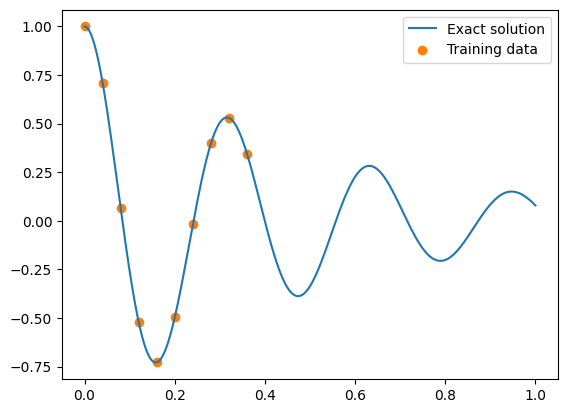

In [ ]:
d, w0 = 2, 20
x = tf.linspace(0.0, 1.0, 500)
x = tf.reshape(x, (-1, 1))
y = oscillator(d, w0, x)
y = tf.reshape(y, (-1, 1))
x_data = x[0:200:20]
y_data = y[0:200:20]

plt.figure()
plt.plot(x, y, label="Exact solution")
plt.scatter(x_data, y_data, color="tab:orange", label="Training data")
plt.legend()
plt.show()

In [ ]:
files = []
tf.random.set_seed(123)

model = FCN(1, 1, 32, 3)
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


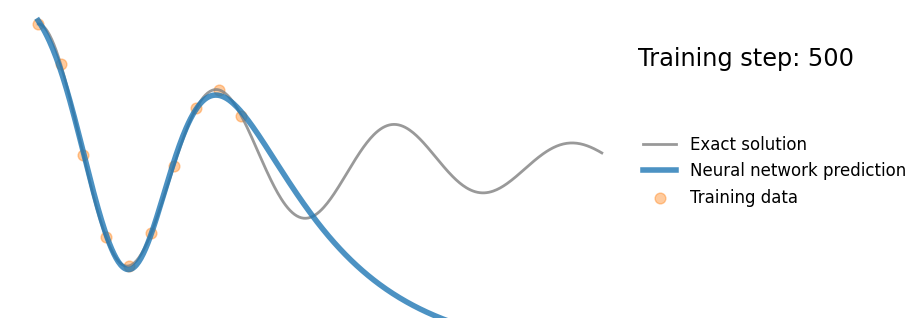

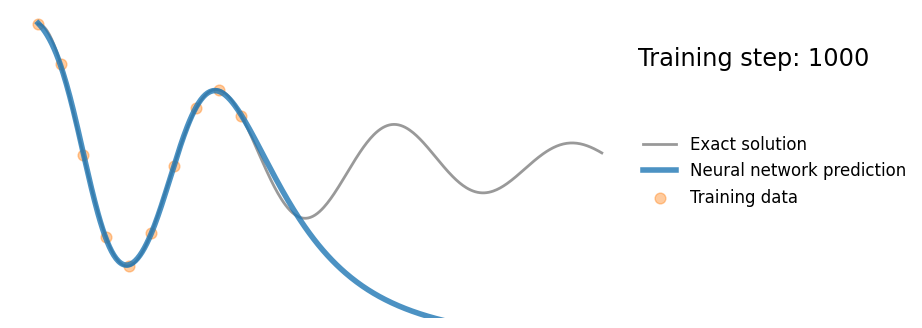

In [ ]:
for i in range(1000):
    with tf.GradientTape() as tape:
        yh = model(x_data, training=True)
        loss = tf.reduce_mean(tf.square(yh - y_data))

    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    if (i + 1) % 10 == 0:
        with tf.GradientTape(persistent=True) as tape:
            yh = model(x)
            yh_detached = tf.stop_gradient(yh)

        plot_result(x, y, x_data, y_data, yh, i=i)
        file = "plots/nn_%.8i.png" % (i + 1)
        plt.savefig(file, bbox_inches='tight', pad_inches=0.1, dpi=100, facecolor="white")
        files.append(file)
        if (i + 1) % 500 == 0:
            plt.show()
        else:
            plt.close("all")

save_gif_PIL("nn.gif", files, fps=20, loop=0)

In [ ]:
x_physics = tf.linspace(0.0, 1.0, 30)
x_physics = tf.reshape(x_physics, (-1, 1))
x_physics = tf.Variable(x_physics, trainable=True, dtype=tf.float32)

mu = 2 * d
k = w0 ** 2

# Re-instantiate the model
model = FCN(1, 1, 32, 3)

# Define the optimizers for PINN
adam_optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)

files = []


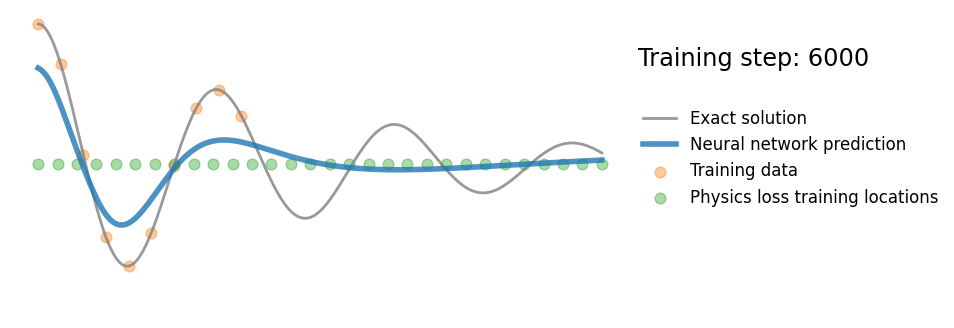

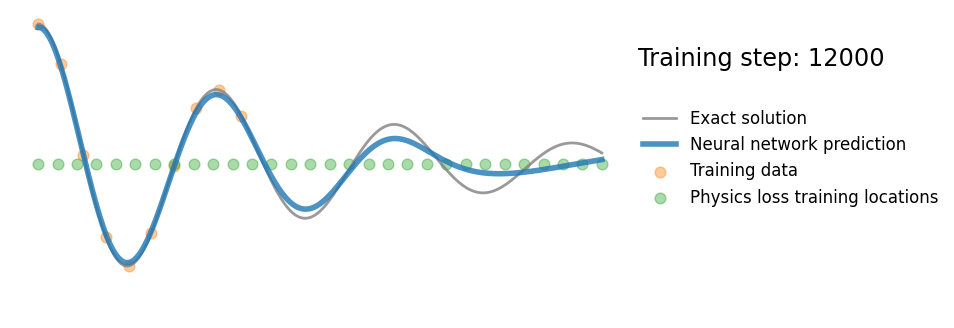

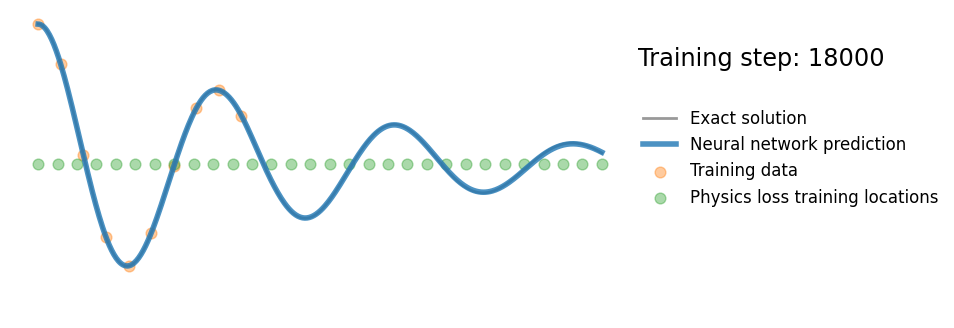

In [ ]:

for i in range(20000):
    with tf.GradientTape(persistent=True) as tape:
        yh = model(x_data)
        loss1 = tf.reduce_mean(tf.square(yh - y_data))
        yhp = model(x_physics)
        dx = tape.gradient(yhp, x_physics)
        dx2 = tape.gradient(dx, x_physics)
        physics = dx2 + mu * dx + k * yhp
        loss2 = 1e-4 * tf.reduce_mean(tf.square(physics))


        loss = loss1 + loss2


    gradients = tape.gradient(loss, model.trainable_variables)
    adam_optimizer.apply_gradients(zip(gradients, model.trainable_variables))
# Reminder : look for better optimizers as well
    if (i + 1) % 150 == 0:
        yh = model(x)
        xp = x_physics
        plot_result(x, y, x_data, y_data, yh.numpy(), xp.numpy(), i=i)
        file = "plots/pinn_%.8i.png" % (i + 1)
        plt.savefig(file, bbox_inches='tight', pad_inches=0.1, dpi=100, facecolor="white")
        files.append(file)
        if (i + 1) % 6000 == 0:
            plt.show()
        else:
            plt.close("all")

save_gif_PIL("pinn.gif", files, fps=20, loop=0)
